In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [1]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [2]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "celeba"
args_.method = "FedEM_adv"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/'
args_.validation = False
args_.num_user = 40
args_.tune_steps = None

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 222.13it/s]


===> Initializing clients..


100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:39<00:00,  2.01it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.922 | Train Acc: 1.464% |Test Loss: 2.923 | Test Acc: 1.297% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [6]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(torch.Tensor([y]))

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

In [14]:
exp_names = ['weights/celeba_noprop/prop_n1/',
             'weights/celeba_noprop/prop_n2/',
             'weights/celeba_noprop/prop_n5/',
             'weights/celeba_noprop/prop_n10/',
             'weights/celeba_noprop/prop_n20/',
             'weights/celeba_noprop/prop_n40/']

train_item = 'train_client_weights.npy'

In [15]:
num_victims = 40
num_exp = len(exp_names)
# Set Up Dictionaries -- list holds the adversary idx
exp_logs = {}

for j in range(num_exp):
    logs_adv = []

    for i in range(num_victims):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None
        
        logs_adv += [adv_dict]
    
    exp_logs[j] = copy.deepcopy(logs_adv)


In [16]:
# Inter Boundary Distance Metric
custom_batch_size = 500


for j in range(num_exp):
    print('processing file', exp_names[j], '...')
    
    # Change name if need be
    args_.save_path = exp_names[j]

    # Import weights for aggregator
    aggregator.load_state(args_.save_path)

    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
        
    weight_name = args_.save_path + train_item
    weights = np.load(weight_name)
    np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

    # Set model weights
    model_weights = []
    num_models = num_victims

    for i in range(num_models):
        model_weights += [weights[i]]


    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0,w1,w2) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0*weights_h[0][key]  + w1*weights_h[1][key] +w2*weights_h[2][key] 
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]
    

    victim_idxs = range(num_victims)

    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)
        # Perform Attacks
        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
        
        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)
        
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 8, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = 4.5, eps_norm = 2)

        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        # t1.check_empirical_metrics(orig_flag = True)

        # Log Performance
        exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = 4.5, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


    del models_test

processing file weights/celeba_noprop/prop_n1/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
processing file weights/celeba_noprop/prop_n2/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv id

Organizing and plotting data

In [17]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']


orig_acc = []
orig_sim = []
adv_acc = []
adv_sim_target = []
adv_sim_untarget = []
adv_target = []
adv_miss = []

for i in range(len(exp_names)):
    orig_acc += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    orig_sim += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_acc += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_target += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_untarget += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_target += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_miss += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    
    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [18]:
def avg_nondiag(array2d):
    d1 = array2d.shape[0]
    d2 = array2d.shape[1]
    
    counter = 0
    val = 0
    
    for i1 in range(d1):
        for i2 in range(d2):
            if i1 != i2:
                if not np.isnan(array2d[i1,i2]):
                    counter+=1
                    val += array2d[i1,i2]
    
    return val/counter

In [19]:
# Edit desired data
x = [1/40,2/40,5/40,10/40,20/40,40/40]
# Acc
y_acc = []
y_robust = []
y_target = []
for i in range(len(exp_names)):
    y_acc += [np.mean(np.diagonal(orig_acc[i]))]
    y_robust += [avg_nondiag(adv_miss[i])]
    y_target += [avg_nondiag(adv_target[i])]
    
print('y_acc', y_acc)
print('y_robust', y_robust)
print('y_target', y_target)

y = [y_acc, y_robust, y_target]

y_acc [0.7188913866877555, 0.6854880079627037, 0.6102111015468836, 0.5092765688896179, 0.6061212807893753, 0.8049384191632271]
y_robust [0.1465758529569333, 0.09085780548481032, 0.09420837725106722, 0.11046540010362291, 0.17263693993146986, 0.3550988939966863]
y_target [0.444629422470408, 0.5211322562968668, 0.24593747291349016, 0.20409645288594847, 0.33858182712811374, 0.44279322812283495]


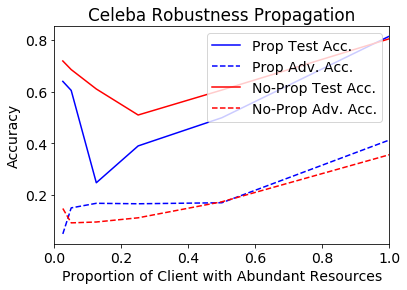

In [4]:
x = [1/40,2/40,5/40,10/40,20/40,40/40]
y_acc_prop = [0.6397054046392441, 0.6047094088047743, 0.24645553743466736, 0.38935257187113165, 0.49872155636549, 0.8148254670202733]
y_robust_prop = [0.04797129174216817, 0.14893330581342945, 0.16673672646761706, 0.16495200387584286, 0.16887224918494048, 0.41209402464760037]
y_target_prop = [0.48718014273261023, 0.2529219545014962, 0.04014811423692281, 0.08019074651594521, 0.09407222415179745, 0.3488737818173315]

y1 = [y_acc_prop, y_robust_prop]

y_acc_no = [0.7188913866877555, 0.6854880079627037, 0.6102111015468836, 0.5092765688896179, 0.6061212807893753, 0.8049384191632271]
y_robust_no = [0.1465758529569333, 0.09085780548481032, 0.09420837725106722, 0.11046540010362291, 0.17263693993146986, 0.3550988939966863]
y_target_no =  [0.444629422470408, 0.5211322562968668, 0.24593747291349016, 0.20409645288594847, 0.33858182712811374, 0.44279322812283495]

y2= [y_acc_no, y_robust_no]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

names1 = ['Prop Test Acc.', 'Prop Adv. Acc.']
names2 = ['No-Prop Test Acc.', 'No-Prop Adv. Acc.']
colors = ['b','r']
types = ['-', '--']

for i in range(len(names1)):
    plt.plot(x,y1[i],label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names2)):
    plt.plot(x,y2[i],label= names2[i], linestyle = types[i], color = colors[1])
plt.legend(frameon=True)
plt.xlim(0, 1);
# plt.ylim(0, 1.0);
plt.xlabel('Proportion of Client with Abundant Resources')
plt.ylabel('Accuracy')
plt.title("Celeba Robustness Propagation")
plt.savefig("Celeba_Robustness_Propagation.png")
